In [1]:
import warnings

# Third-party
from astropy.io import fits, ascii
import astropy.table as tbl
import astropy.time as atime
import astropy.coordinates as coord
import astropy.units as u

import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('apw-notebook')
%matplotlib inline
import corner

from scipy.optimize import minimize

from ebak.singleline import RVData, OrbitModel
from ebak.units import usys
from ebak import SimulatedRVOrbit

In [2]:
troup = tbl.Table(np.genfromtxt("../data/troup16-dr12.csv", delimiter=",", names=True, dtype=None))

In [3]:
# troup_i = np.where((troup['NVISITS'] > 30) & (troup['SLOPE'] == 0) & (troup['ECC'] < 0.2))[0][0]
# troup_i = np.where((troup['NVISITS'] > 10) & (troup['SLOPE'] == 0) & (troup['ECC'] < 0.4))[0][0]
troup_i = 211
troup_i

211

In [4]:
print(troup.colnames)

['APOGEE_ID', 'NVISITS', 'SNR', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK', 'AK_SRC', 'RA', 'DEC', 'GLON', 'GLAT', 'PMRA', 'PMDEC', 'PM_SRC', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'FE_H', 'FE_H_ERR', 'SPARAMTYPE', 'STARTYPE', 'MSTAR', 'MSTAR_ERR', 'RSTAR', 'RSTAR_ERR', 'DIST', 'DIST_ERR', 'MSTAR_SRC', 'VJITTER', 'BASELINE', 'SIGMA_V', 'SIG_RVVAR', 'PERIOD', 'PERIOD_ERR', 'SEMIAMP', 'SEMIAMP_ERR', 'ECC', 'ECC_ERR', 'OMEGA', 'T0', 'TPERI', 'V0', 'SLOPE', 'NITER', 'CHI2', 'DOF', 'FIT_RMS', 'PUI', 'VUI', 'MASSFN', 'MSINI', 'SEMIMAJ', 'f0']


In [5]:
_tbl = fits.getdata("../data/allVisit-l30e.2.fits", 1)
one_target = tbl.Table(_tbl[_tbl['APOGEE_ID'] == troup['APOGEE_ID'].astype(str)[troup_i]])
print(one_target['APOGEE_ID'][0])

2M13101232+1811409


In [6]:
# one_target = tbl.Table(_tbl[_tbl['APOGEE_ID'].astype(str) == "2M03080601+7950502"])
# troup_i, = np.where(troup['APOGEE_ID'].astype(str) == "2M03080601+7950502")[0]
# one_target = tbl.Table(_tbl[_tbl['APOGEE_ID'].astype(str) == "2M00283971+8530377"])
# troup_i, = np.where(troup['APOGEE_ID'].astype(str) == "2M00283971+8530377")[0]
# troup_i

In [7]:
ecc = troup[troup_i]['ECC']
m_f = troup[troup_i]['MASSFN']*u.Msun
K = troup[troup_i]['SEMIAMP']*u.m/u.s

period = troup[troup_i]['PERIOD']*u.day
asini = (K * period/(2*np.pi) * np.sqrt(1 - ecc**2)).to(u.au)

omega = troup[troup_i]['OMEGA']*u.degree
v0 = troup[troup_i]['V0']*u.m/u.s
v_slope = troup[troup_i]['SLOPE']*u.m/u.s/u.day

t_peri = atime.Time(troup[troup_i]['TPERI'], format='jd', scale='tcb')
phi0 = ((2*np.pi*(t_peri.tcb.mjd - 55555.) / period.to(u.day).value) % (2*np.pi)) * u.radian

In [8]:
rv = np.array(one_target['VHELIO']) * u.km/u.s
ivar = 1 / (np.array(one_target['VRELERR'])*u.km/u.s)**2
t = atime.Time(np.array(one_target['JD']), format='jd', scale='tcb')

data = RVData(t, rv, ivar)

In [9]:
troup_orbit = SimulatedRVOrbit(P=period, a_sin_i=asini, ecc=ecc, 
                               omega=omega, phi0=phi0, v0=0*u.km/u.s)

# def min_func(p, data, _orbit):
#     a_sin_i, omega, phi0, v0 = p
    
#     _orbit._a_sin_i = a_sin_i
#     _orbit._omega = omega
#     _orbit._phi0 = phi0
#     _orbit._v0 = v0
    
#     return np.sum(data._ivar * (_orbit._generate_rv_curve(data._t) - data._rv)**2)

def min_func(p, data, _orbit):
    omega, phi0, v0 = p
    
#     _orbit._a_sin_i = a_sin_i
    _orbit._omega = omega
    _orbit._phi0 = phi0
    _orbit._v0 = v0
    
    return np.sum(data._ivar * (_orbit._generate_rv_curve(data._t) - data._rv)**2)

In [10]:
# x0 = [asini.decompose(usys).value, omega.decompose(usys).value,
#       phi0.decompose(usys).value, -v0.decompose(usys).value]
x0 = [omega.decompose(usys).value, phi0.decompose(usys).value, -v0.decompose(usys).value]
res = minimize(min_func, x0=x0, method='powell',
               args=(data,troup_orbit.copy()))
#                bounds=[(1e-8, None),(None,None),(None,None),(None,None)])

In [11]:
res.success, res.x

(True, array([  7.14427705e-01,   5.60746323e+00,  -4.82661687e-03]))

In [12]:
orbit = troup_orbit.copy()
# orbit._a_sin_i, orbit._omega, orbit._phi0, orbit._v0 = res.x
orbit._omega, orbit._phi0, orbit._v0 = res.x

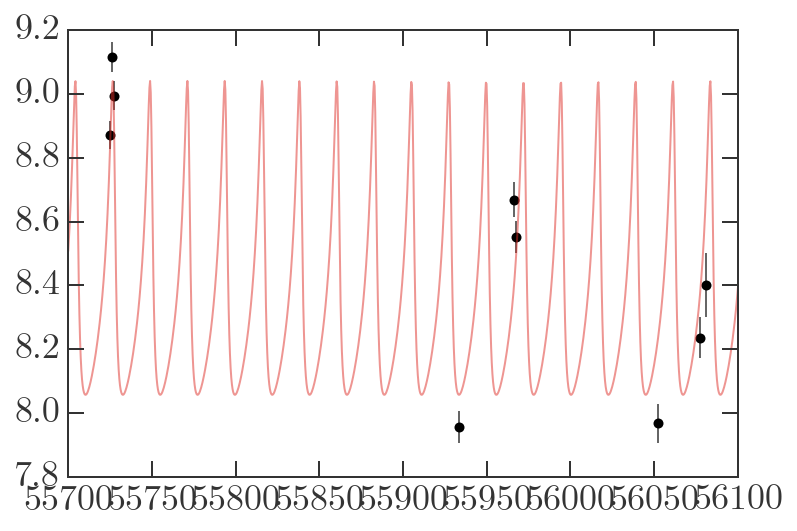

In [13]:
data.plot()
orbit.plot(ax=plt.gca())

In [15]:
model = OrbitModel(data=data, orbit=orbit)

In [22]:
model.ln_prior()

13.446639626749333

In [23]:
np.log(model.orbit._P)

3.1050224877923243

In [24]:
n_steps = 1024
n_walkers = 256
p0 = emcee.utils.sample_ball(model.get_par_vec(), 
                             1E-3*model.get_par_vec(),
                             size=n_walkers)

# special treatment for ln_P
p0[:,0] = np.random.normal(np.log(model.orbit._P), 0.1, size=p0.shape[0])

# special treatment for s
p0[:,6] = np.abs(np.random.normal(0, 1E-3, size=p0.shape[0]) * u.km/u.s).decompose(usys).value

sampler = emcee.EnsembleSampler(n_walkers, dim=p0.shape[1], lnpostfn=model)

In [25]:
pos,_,_ = sampler.run_mcmc(p0, N=n_steps)

/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/ebak-0.1.dev0-py3.5.egg/ebak/celestialmechanics.py:101: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)


In [1]:
for i in range(p0.shape[1]):
    plt.figure()
    plt.ylabel(model.vec_labels[i])
    plt.plot(sampler.chain[...,i].T, drawstyle='steps', alpha=0.1, marker=None)
#     plt.ylim(lims[i])

In [27]:
def plot_rv_curve_samples(sampler, ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
        
    data.plot(ax=ax, zorder=100)
    
    for p in sampler.chain[:,-1]:
        orbit = model.from_vec(p).orbit
        orbit.plot(ax=ax, alpha=0.1)

    _diff = data.rv.max()-data.rv.min()
    ax.set_ylim((data.rv.min()-0.25*_diff).to(u.km/u.s).value, 
                (data.rv.max()+0.25*_diff).to(u.km/u.s).value)

    ax.set_xlabel('MJD')
    ax.set_ylabel('RV [km/s]')
    
    return ax.figure

/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/ebak-0.1.dev0-py3.5.egg/ebak/celestialmechanics.py:101: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)


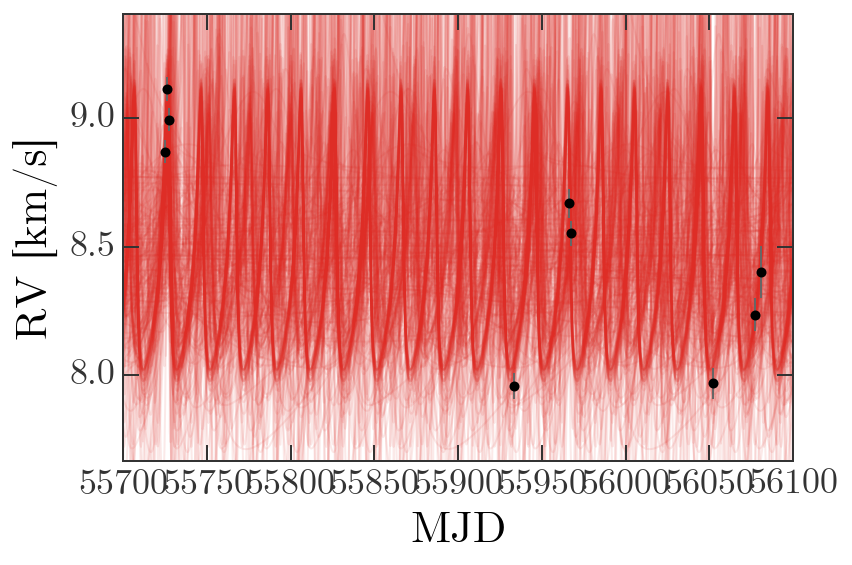

In [28]:
_ = plot_rv_curve_samples(sampler)

In [22]:
flatchain = np.vstack(sampler.chain[:,-256:])
plot_pars = model.vec_to_plot_pars(flatchain)

In [23]:
troup_vals = [np.log(period.to(u.day).value), m_f.value, ecc, omega.to(u.degree).value, 
              t_peri.mjd, -v0.to(u.km/u.s).value, 0.]

In [2]:
fig = corner.corner(plot_pars, labels=model.plot_labels, truths=troup_vals)